# ALS Implementation

In [10]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 1. Initialize parameters

- r_lambda: normalization parameter
- alpha: confidence level
- nf: dimension of latent vector of each user and item
- initilzed values(40, 200, 40) are the best parameters from the paper

In [11]:
r_lambda = 40
nf = 200
alpha = 40

## 2. rating matrix

In [12]:
import numpy as np

# sample rating matrix
R = np.array([[0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0],
              [0, 3, 4, 0, 3, 0, 0, 2, 2, 0, 0],
              [0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0],
              [0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 5],
              [0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4],
              [0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0],
              [0, 0, 0, 3, 0, 0, 0, 0, 4, 5, 0]])
R.shape

(10, 11)

## 3. Initalize user and item latent factor matrix
 : 아주 작은 랜덤한 값들로 행렬의 값을 초기화 시킴 -> 이를 통해 한쪽 
정보를 상수로 고정한 상태에서 반대편 matrix를 학습
 - nu : number of users (10)
 - ni : number of items (11)
 - nf : dimension of latent vector

In [13]:
nu = R.shape[0]
ni = R.shape[1]

# initialize X and Y with very small values
X = np.random.rand(nu, nf) * 0.01 # 10x200
Y = np.random.rand(ni, nf) * 0.01 # 11x200

X, Y

(array([[0.00152801, 0.00757564, 0.00923784, ..., 0.00490042, 0.00697526,
         0.00954676],
        [0.0091762 , 0.00020842, 0.00542215, ..., 0.00064578, 0.00903261,
         0.00724798],
        [0.00148628, 0.00628547, 0.00604668, ..., 0.00497305, 0.00232862,
         0.00901012],
        ...,
        [0.00235099, 0.00393322, 0.00918248, ..., 0.00974353, 0.00444581,
         0.00186488],
        [0.00547913, 0.00562956, 0.00104005, ..., 0.00659107, 0.00523891,
         0.00125358],
        [0.00193838, 0.00580671, 0.00466999, ..., 0.00584544, 0.00520098,
         0.00723732]]),
 array([[0.00942033, 0.00838059, 0.00283322, ..., 0.00669   , 0.00111067,
         0.00387789],
        [0.00243604, 0.00722863, 0.00577154, ..., 0.00728208, 0.00484407,
         0.00569207],
        [0.00219446, 0.00927742, 0.00120476, ..., 0.00207732, 0.00900426,
         0.00639849],
        ...,
        [0.00116326, 0.00210305, 0.00749175, ..., 0.0019529 , 0.00388187,
         0.00557575],
        [0.0

## 4. Initialize Binary Rating Matrix
### (선호도 행렬 P 설정)
 : 주어진 학습용 평점 테이블을 0과1로  이뤄진 binary rating matrix P로 변경<br>
 - Convert original rating matrix R into P
 - Pui = 1 if Rui > 0 
 - Pui = 0 if Rui = 0

In [5]:
P = np.copy(R)
P[P > 0] = 1
P

array([[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]])

## 5. Initialize Confidence Matrix 
### (신로도 행렬 C 설정)
 : 주어진 학습 평점 테이블에 confidence level을 적용한 C행렬 계산

 - 신뢰도 행렬을 이횽해 평점이 부재한 테이터도 낮은 신뢰도 하에서 분석에 활용 가능
  
 - Initialize Confidence Matrix C
 - Cui = 1 + alpha * R 


In [14]:
C = 1 +alpha * R
print(C)
C.shape

[[  1   1   1 161 161   1   1   1   1   1   1]
 [  1   1   1   1   1   1   1   1   1   1  41]
 [  1   1   1   1   1   1   1  41   1 161   1]
 [  1 121 161   1 121   1   1  81  81   1   1]
 [  1 201 201   1   1   1   1   1   1   1   1]
 [  1   1   1   1   1   1 201   1   1 201   1]
 [  1   1 161   1   1   1   1   1   1   1 201]
 [  1   1   1   1   1 161   1   1   1   1 161]
 [  1   1   1   1   1   1 201   1   1 201   1]
 [  1   1   1 121   1   1   1   1 161 201   1]]


(10, 11)

In [74]:
i = 0
Ci = np.diag(C[:, i])
Ci

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

## 6. Loss Function 설정
 - C: confidence matrix
 - P: binary rating matrix
 - X: user latent matrix
 - Y: item latent matrix
 - r_lambda: regularization lambda
 - xTy: predict matrix
 - Total_loss = (confidence_level * predict loss) + regularization loss

In [7]:
def loss_function(C, P, xTy, X, Y, r_lambda) :
    predict_error = np.square(P-xTy) # (관측치 - 예측치)^2
    confidence_error = np.sum(C*predict_error) # 오차값이 크더라도, 신뢰도가 낮다면 적게 반영하며, 오차값이 작더라도 신뢰도가 크다면 오차를 크게 반영
    regularization = r_lambda * (np.sum(np.square(X)) + np.sum(np.square(Y)))
    total_loss = confidence_error + regularization
    return np.sum(predict_error), confidence_error, regularization, total_loss

## 7. Optimization Function for user and Item
- X[u] = (yTCuy + lambda*I)^-1yTCuy
- Y[i] = (xTCix + lambda*I)^-1xTCix
- two formula is the same when it changes X to Y and u to i

In [8]:
def optimize_user(X, Y, C, P, nu, nf, r_lambda) :
    """
    optimize user matrix
    """
    yT = np.transpose(Y)
    for u in range(nu):
        Cu = np.diag(C[u]) # np.diag : 대각 행렬 C행렬을 순차적으로 곱해주기 위해서
        yT_Cu_y = np.matmul(np.matmul(yT, Cu), Y)
        lI = np.dot(r_lambda, np.identity(nf)) # 정규화
        yT_Cu_pu = np.matmul(np.matmul(yT, Cu), P[u])
        X[u] = np.linalg.solve(yT_Cu_y + lI, yT_Cu_pu)

def optimize_item(X, Y, C, P, ni, nf, r_lambda):
    """
    optimize item matrix
    """
    xT = np.transpose(X)
    for i in range(ni):
        Ci = np.diag(C[:, i])
        xT_Ci_x = np.matmul(np.matmul(xT, Ci), X)
        lI = np.dot(r_lambda, np.identity(nf))
        xT_Ci_pi = np.matmul(np.matmul(xT, Ci), P[:, i])
        Y[i] = np.linalg.solve(xT_Ci_x + lI, xT_Ci_pi)

In [75]:
xT = np.transpose(X)
for i in range(ni):
    Ci = np.diag(C[:, i])
    xT_Ci_x = np.matmul(np.matmul(xT, Ci), X)
    lI = np.dot(r_lambda, np.identity(nf))
    xT_Ci_pi = np.matmul(np.matmul(xT, Ci), P[:, i])
    Y[i] = np.linalg.solve(xT_Ci_x + lI, xT_Ci_pi)

In [81]:
xT_Ci_x.shape
lI.shape
xT_Ci_pi.shape
P[:, i].shape

(200, 200)

(200, 200)

(200,)

(10,)

## 8. Train
 - usually ALS algorithm repeat train steps for 10~15times

In [39]:
predict_errors = []
confidence_errors = []
regularization_list = []
total_losses = []

for i in range(15):
    if i!=0:   
        optimize_user(X, Y, C, P, nu, nf, r_lambda)
        optimize_item(X, Y, C, P, ni, nf, r_lambda)
    predict = np.matmul(X, np.transpose(Y))
    predict_error, confidence_error, regularization, total_loss = loss_function(C, P, predict, X, Y, r_lambda)
    
    predict_errors.append(predict_error)
    confidence_errors.append(confidence_error)
    regularization_list.append(regularization)
    total_losses.append(total_loss)
    
    print('----------------step %d----------------' % i)
    print("predict error: %f" % predict_error)
    print("confidence error: %f" % confidence_error)
    print("regularization: %f" % regularization)
    print("total loss: %f" % total_loss)
    
predict = np.matmul(X, np.transpose(Y))
print('final predict')
print([predict])

----------------step 0----------------
predict error: 22.628862
confidence error: 3442.769641
regularization: 19.336987
total loss: 3462.106628
----------------step 1----------------
predict error: 30.957115
confidence error: 285.638645
regularization: 639.397642
total loss: 925.036287
----------------step 2----------------
predict error: 34.024191
confidence error: 137.844707
regularization: 650.759387
total loss: 788.604093
----------------step 3----------------
predict error: 32.130058
confidence error: 119.829810
regularization: 650.760389
total loss: 770.590198
----------------step 4----------------
predict error: 29.562359
confidence error: 109.343120
regularization: 653.473816
total loss: 762.816936
----------------step 5----------------
predict error: 27.065492
confidence error: 102.318145
regularization: 656.420266
total loss: 758.738411
----------------step 6----------------
predict error: 24.979342
confidence error: 97.495774
regularization: 658.869386
total loss: 756.365160

Text(0.5, 1.0, 'Predict Error')

Text(0.5, 1.0, 'Confidence Error')

Text(0.5, 1.0, 'Regularization')

Text(0.5, 1.0, 'Total Loss')

<Figure size 432x288 with 0 Axes>

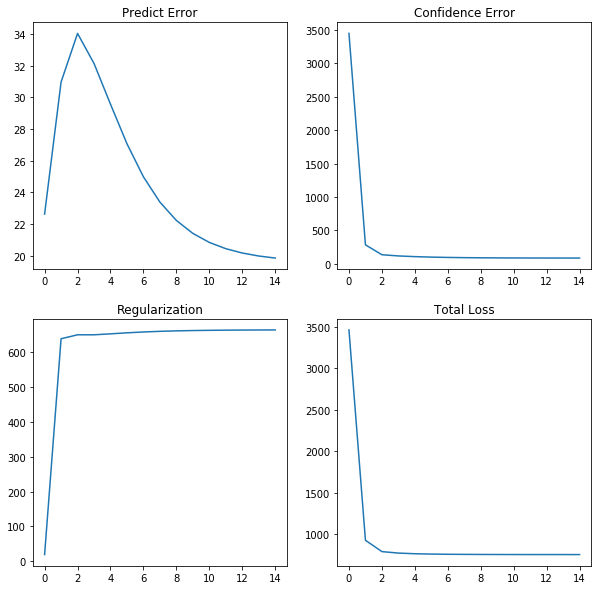

In [40]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.subplots_adjust(wspace=100.0, hspace=20.0)
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
predict_error_line = fig.add_subplot(2, 2, 1)
confidence_error_line = fig.add_subplot(2, 2, 2)
regularization_error_line = fig.add_subplot(2, 2, 3)
total_loss_line = fig.add_subplot(2, 2, 4)

predict_error_line.set_title("Predict Error") 
predict_error_line.plot(predict_errors)

confidence_error_line.set_title("Confidence Error")
confidence_error_line.plot(confidence_errors)

regularization_error_line.set_title("Regularization")
regularization_error_line.plot(regularization_list)

total_loss_line.set_title("Total Loss")
total_loss_line.plot(total_losses)
plt.show()